<a href="https://colab.research.google.com/github/Cuzime/ASTRON-128/blob/main/ZTF_stamp_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install ztfquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.7/256.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 69.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.1 which is incompatible.
orbax-checkpoint 0.4.1 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.
tensorfl

In [3]:
from ztfquery import query
from astropy import time
import time as ttime

from astropy.io import fits
from astropy.visualization import PercentileInterval, AsinhStretch, MinMaxInterval, SqrtStretch, ImageNormalize, SinhStretch
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os

# Get images between 2021-04-02 and 2022-04-02


In [4]:
zquery = query.ZTFQuery()
tstart = time.Time("2021-04-02").jd
tend = time.Time("2022-04-10").jd
#zquery.load_metadata(kind="raw", sql_query=f"obsjd BETWEEN {tstart} AND {tend} AND filtercode='zg' AND ccdid=8")
zquery.load_metadata(kind="raw", sql_query=f"obsjd BETWEEN {tstart} AND {tend}")

zquery.metatable

Enter your irsa login: agoh@berkeley.edu
··········


,infobits,field,ccdid,fid,filtercode,nid,expid,itid,imgtype,imgtypecode,...,exptime,seeing,airmass,moonillf,moonesb,telra,teldec,ccdrot,ipac_pub_date,ipac_gid
0,0,506,1,2,zr,1552,155212723,1,object,o,...,30,NaN,2.420,-0.750595,0,50.6634,11.75,0,2022-11-08 00:00:00+00,2
1,0,506,2,2,zr,1552,155212723,1,object,o,...,30,NaN,2.420,-0.750595,0,50.6634,11.75,0,2022-11-08 00:00:00+00,2
2,0,506,3,2,zr,1552,155212723,1,object,o,...,30,NaN,2.420,-0.750595,0,50.6634,11.75,0,2022-11-08 00:00:00+00,2
3,0,506,4,2,zr,1552,155212723,1,object,o,...,30,NaN,2.420,-0.750595,0,50.6634,11.75,0,2022-11-08 00:00:00+00,2
4,0,506,5,2,zr,1552,155212723,1,object,o,...,30,NaN,2.420,-0.750595,0,50.6634,11.75,0,2022-11-08 00:00:00+00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008444,0,597,12,2,zr,1924,192452045,1,object,o,...,30,NaN,2.313,0.523383,0,339.6260,18.95,0,2022-07-07 00:00:00+00,1
2008445,0,597,13,2,zr,1924,192452045,1,object,o,...,30,NaN,2.313,0.523383,0,339.6260,18.95,0,2022-07-07 00:00:00+00,1
2008446,0,597,14,2,zr,1924,192452045,1,object,o,...,30,NaN,2.313,0.523383,0,339.6260,18.95,0,2022-07-07 00:00:00+00,1
2008447,0,597,15,2,zr,1924,192452045,1,object,o,...,30,NaN,2.313,0.523383,0,339.6260,18.95,0,2022-07-07 00:00:00+00,1


In [7]:
# set size of stamps
size = 256
step = int(size/2)

def get_image(file_path, quad):
    hdu_1 = fits.open(file_path)
    image_data = hdu_1[quad].data
    hdu_1.close()

    return image_data

def get_stamps(image):
    # get image dimensions
    naxis1,naxis2 = np.shape(image)
    x_centers = np.arange(step, naxis1-step, step)
    y_centers = np.arange(step, naxis2-step, step)
    stamps = []
    for x_center in x_centers:
        for y_center in y_centers:
            stamp = image[y_center-step:y_center+step, x_center-step:x_center+step]
            stamps.append(stamp)

    stamps = np.array(stamps)

    return stamps.reshape(stamps.shape[0], stamps.shape[1], stamps.shape[2], 1)

In [8]:
index_list = np.random.randint(0, len(zquery.metatable), size = 100)
np.random.shuffle(index_list)
urls, locations = zquery.download_data(suffix="test.fits", source="local", download_dir=None,
                                          show_progress=True, nodl=True, indexes=index_list, overwrite = True)
print(urls[0][28:])
print(urls[0])

ztf_20211119092766_000636_zr_c01_o.fits.fz
./Data/raw/2021/1119/092766/ztf_20211119092766_000636_zr_c01_o.fits.fz


In [ ]:
count = 0
for i in range(1000):
  start = ttime.time()
  # get random indexes from zquery.metatable
  index_list = np.random.randint(0, len(zquery.metatable), size = 20)

  # DOWNLOAD DATA INTO LOCAL DIRECTORY
  urls, locations = zquery.download_data(suffix="test.fits", source="local", download_dir=None,
                                          show_progress=True, nodl=True, indexes=index_list, overwrite = True)
  zquery.download_data("test.fits", nprocess=20, show_progress=True, indexes=index_list)
  end = ttime.time()
  print(end-start)
  # FOR EACH URL/IMAGE make one normalized stamp
  start = ttime.time()
  for url in urls:
    file_path = url
    file_name = url[28:]
    quad = 1

    # get image
    image_data = get_image(file_path, quad)

    # log10 scale image
    interval = MinMaxInterval()
    vmin, vmax = interval.get_limits(image_data)
    image_log = np.log10(image_data-vmin+1)

    # GET STAMPS of log scaled image and get random stamp
    stamps = get_stamps(image_log)
    stamp_idx = np.random.randint(0,len(stamps)-1)

    # SAVE SINGLE STAMP
    hdu = fits.PrimaryHDU(stamps[stamp_idx])
    hdu.writeto(f'drive/MyDrive/ZTFquerystamps/{file_name}_{quad}.fits', overwrite=True)

  end = ttime.time()
  print(end-start)
  shutil.rmtree('./Data')

  count += 1
  print(count)



12.054218053817749
9.623476266860962
1
16.714170694351196
9.503690242767334
2
20.87967872619629
9.543486833572388
3
16.624961137771606
9.616044521331787
4
13.850630521774292
9.527241468429565
5
18.32237935066223
9.560912847518921
6
23.100193977355957
9.558398485183716
7
17.941956758499146
9.553371667861938
8
11.06838321685791
9.58565878868103
9
9.05480408668518
9.61999797821045
10
12.696417808532715
9.599710464477539
11
17.883138418197632
9.557173490524292
12
24.56919240951538
9.572459936141968
13
17.2181077003479
9.614654541015625
14
22.19617795944214
9.59453535079956
15
21.25002431869507
9.631271839141846
16
12.07388710975647
9.570858716964722
17
7.243560314178467
9.966350078582764
18
16.82021188735962
9.600770711898804
19
10.76357889175415
9.56828260421753
20
20.30582547187805
9.613903999328613
21
14.76956844329834
9.818527221679688
22
15.014841794967651
9.59927225112915
23
17.322469234466553
9.553579807281494
24
13.288844585418701
9.61797833442688
25
20.603901147842407
9.5704452991

In [ ]:
# check ZTFquerystamps list
folder_path = '/content/drive/MyDrive/ZTFquerystamps'
file_list = os.listdir(folder_path)
print(file_list)
print(len(file_list))

['ztf_20210405203715_000757_zg_c14_o.fits.fz_1.fits', 'ztf_20210608219109_000713_zr_c11_o.fits.fz_1.fits', 'ztf_20211202136898_001335_zr_c05_o.fits.fz_1.fits', 'ztf_20210516247361_000523_zr_c03_o.fits.fz_1.fits', 'ztf_20210826319248_000723_zg_c02_o.fits.fz_1.fits', 'ztf_20210607332164_000331_zr_c10_o.fits.fz_1.fits', 'ztf_20211010174201_000384_zr_c16_o.fits.fz_1.fits', 'ztf_20210412265856_000478_zi_c15_o.fits.fz_1.fits', 'ztf_20210724306146_000647_zr_c04_o.fits.fz_1.fits', 'ztf_20211111249653_001241_zg_c06_o.fits.fz_1.fits', 'ztf_20211114298924_000405_zg_c04_o.fits.fz_1.fits', 'ztf_20210628343519_000772_zg_c15_o.fits.fz_1.fits', 'ztf_20220405502708_000771_zr_c06_o.fits.fz_1.fits', 'ztf_20210525213854_000627_zr_c10_o.fits.fz_1.fits', 'ztf_20211112446713_000666_zr_c12_o.fits.fz_1.fits', 'ztf_20210922445938_000662_zr_c11_o.fits.fz_1.fits', 'ztf_20210405273090_000371_zr_c05_o.fits.fz_1.fits', 'ztf_20210512360405_000629_zg_c16_o.fits.fz_1.fits', 'ztf_20210919265185_000492_zg_c07_o.fits.fz_1

In [ ]:
import shutil

shutil.rmtree('./Data')


(256, 256, 1)


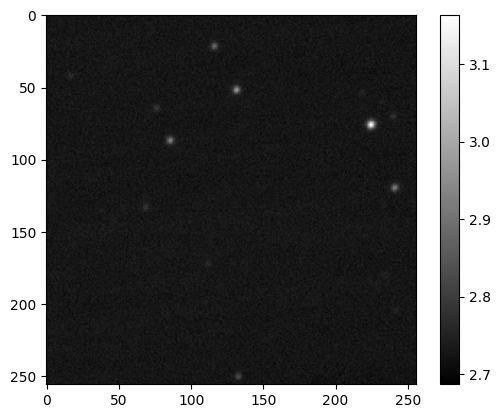

In [ ]:
# check out some stamps in ZTFquerystamps

idx = np.random.randint(0, len(file_list)-1)
path = folder_path + '/' + file_list[idx]
hdu_1 = fits.open(path)
image_data = hdu_1[0].data
hdu_1.close()

print(np.shape(image_data))
plt.imshow(image_data.reshape(256,256), cmap = 'gray')
plt.colorbar()